# Packages

In [1]:
import os
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypower.api as pp
from datetime import datetime
import nygrid.opf as opf


# Multi-period OPF

In [3]:
start_date = datetime(2016, 8, 5, 0, 0, 0)
end_date = datetime(2016, 8, 16, 0, 0, 0)

# Read load profile
datadir = '../data'
filename = os.path.join(datadir, f'loadprofile_{start_date.year}.csv')
load_profile = pd.read_csv(filename, parse_dates=['TimeStamp'], index_col='TimeStamp')

load_profile = load_profile.loc[start_date:end_date, :]

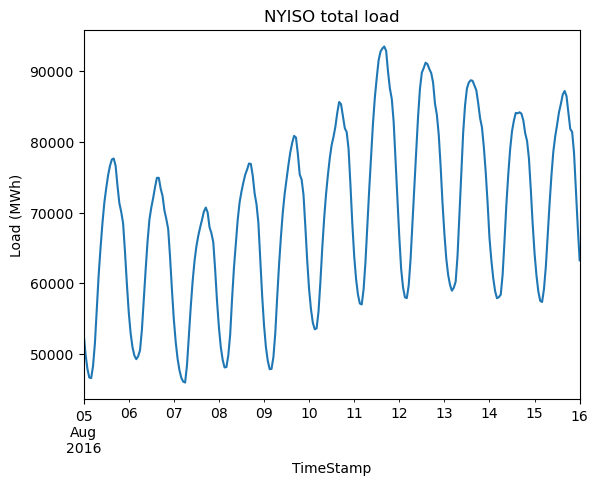

In [4]:
total_load = load_profile.sum(axis=1)
total_load.plot()
plt.ylabel('Load (MWh)')
plt.title('NYISO total load')
plt.show()

In [5]:
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
num_day = len(timestamp_list) - 1


In [6]:
# Only run for one day
d = 7
start_time = timestamp_list[d]
end_time = timestamp_list[d+1]
print(f'Start time: {start_time}')
print(f'End time: {end_time}')
load = load_profile.loc[start_time:end_time, :].to_numpy()

Start time: 2016-08-12 00:00:00
End time: 2016-08-13 00:00:00


In [7]:
# Read MATPOWER case file
filename = os.path.join(datadir, 'ny_grid.mat')
ppc = pp.loadcase(filename)

(ppc_int, B, Bf, gen_map, load_map, load_pu, gencost_0, gencost_1, dc_idx_f, dc_idx_t,
    gen_min, gen_max, br_min, br_max, ramp_down, ramp_up, if_map, if_lims) = opf.process_ppc(ppc, load)

In [8]:
# Multi-period OPF
model_multi = opf.multi_opf(B, Bf, gen_map, load_map, load_pu, gencost_0, gencost_1, dc_idx_f, dc_idx_t,
                gen_min, gen_max, br_min, br_max, ramp_down, ramp_up, if_map, if_lims)



In [11]:
# model_multi.c_br_min.deactivate()
# model_multi.c_br_max.deactivate()
# Solve the problem
solver = SolverFactory('glpk')
results_multi = solver.solve(model_multi, tee=True)

if opf.check_model_status(results_multi):
     print('%.2f' % model_multi.obj())

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\xjtuy\AppData\Local\Temp\tmp9239k7od.glpk.raw --wglp C:\Users\xjtuy\AppData\Local\Temp\tmp3hhvv6qj.glpk.glp
 --cpxlp C:\Users\xjtuy\AppData\Local\Temp\tmp9qmq1ik6.pyomo.lp
Reading problem data from 'C:\Users\xjtuy\AppData\Local\Temp\tmp9qmq1ik6.pyomo.lp'...
36095 rows, 10701 columns, 66539 non-zeros
192283 lines were read
Writing problem data to 'C:\Users\xjtuy\AppData\Local\Temp\tmp3hhvv6qj.glpk.glp'...
164459 lines were written
GLPK Simplex Optimizer 5.0
36095 rows, 10701 columns, 66539 non-zeros
Preprocessing...
9240 rows, 8650 columns, 29280 non-zeros
Scaling...
 A: min|aij| =  1.061e-01  max|aij| =  5.058e+02  ratio =  4.766e+03
GM: min|aij| =  4.212e-02  max|aij| =  2.374e+01  ratio =  5.636e+02
EQ: min|aij| =  1.774e-03  max|aij| =  1.000e+00  ratio =  5.636e+02
Constructing initial basis...
Size of triangular part is 9190
      0: obj =   1.162246333e+08 inf =   3.450e+03 (1162)
   7699

# Process the results

In [12]:
results = opf.opf_results_multi(model_multi, ppc_int, start_time, end_time)

In [13]:
results.keys()

dict_keys(['PG', 'VA', 'PF', 'IF', 'LMP'])

In [21]:
# Read thermal generator info table
filename = os.path.join(datadir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,maxRamp10,maxRamp30,maxRamp60,HeatRateLM_R2,HeatRateQM_R2,BusName,NCOST,cost_1,cost_0
0,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,0.733333,7.333333,22.00,44.0,0.862443,0.891407,62,1,22.682017,-40.234372
1,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.591500,-74.202700,349.0,96.0,2.850000,28.500000,85.50,171.0,0.995837,0.995860,82,1,25.306225,736.980064
2,Arthur Kill ST 3,23513,J,Steam Turbine,Natural Gas,40.591500,-74.202700,539.0,1.0,3.108333,31.083333,93.25,186.5,0.986235,0.991460,82,1,25.957282,993.894899
3,Astoria 2,24149,J,Steam Turbine,Natural Gas,40.786900,-73.912200,153.0,1.0,0.808333,8.083333,24.25,48.5,0.987563,0.988910,82,1,31.302863,430.832898
4,Astoria 3,23516,J,Steam Turbine,Fuel Oil 2,40.786900,-73.912200,756.0,40.0,6.033333,60.333333,181.00,362.0,0.996075,0.996269,82,1,66.084194,3680.943877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Shoreham 1,23715,K,Combustion Turbine,Fuel Oil 2,40.957200,-72.866400,52.9,0.0,0.881667,8.816667,26.45,52.9,0.000000,0.000000,80,1,195.331050,0.000000
223,Shoreham 2,23716,K,Jet Engine,Fuel Oil 2,40.957200,-72.866400,18.6,0.0,0.310000,3.100000,9.30,18.6,0.000000,0.000000,80,1,195.331050,0.000000
224,South Cairo,23612,G,Combustion Turbine,Kerosene,42.291275,-73.986452,21.6,0.0,0.360000,3.600000,10.80,21.6,0.000000,0.000000,39,1,195.331050,0.000000
225,Southold 1,23719,K,Combustion Turbine,Fuel Oil 2,41.105900,-72.376100,14.0,0.0,0.233333,2.333333,7.00,14.0,0.000000,0.000000,80,1,195.331050,0.000000


In [22]:
gen_info.iloc[5, :]

NYISOName            Astoria 5
PTID                     23518
Zone                         J
UnitType         Steam Turbine
FuelType            Fuel Oil 2
Latitude               40.7869
Longitude             -73.9122
maxPower                 776.0
minPower                   2.0
maxRampAgc            6.466667
maxRamp10            64.666667
maxRamp30                194.0
maxRamp60                388.0
HeatRateLM_R2         0.984701
HeatRateQM_R2         0.984698
BusName                     82
NCOST                        1
cost_1               64.720037
cost_0             3918.904933
Name: 5, dtype: object

In [24]:
num_thermal = gen_info.shape[0]
results_pg = results['PG']
thermal_pg = results_pg.iloc[:, :num_thermal]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
thermal_pg = thermal_pg.rename(columns=gen_rename)
thermal_pg

,Allegany,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,Astoria 3,Astoria 5,Astoria CC 1,Astoria CC 2,Astoria East Energy - CC1,Astoria East Energy - CC2,...,Northport GT,Ravenswood 01,Ravenswood 10,Ravenswood 11,S Hampton 1,Shoreham 1,Shoreham 2,South Cairo,Southold 1,St. Elizabeth Medical Center
2016-08-12 00:00:00,66.0,349.0,539.0,153.0,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 01:00:00,66.0,349.0,539.0,104.5,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 02:00:00,66.0,349.0,539.0,56.0,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 03:00:00,66.0,349.0,539.0,7.5,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 04:00:00,66.0,349.0,539.0,56.0,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 05:00:00,66.0,349.0,539.0,104.5,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 06:00:00,66.0,349.0,539.0,153.0,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 07:00:00,66.0,349.0,539.0,153.0,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 08:00:00,66.0,349.0,539.0,153.0,40.0,2.000000,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
2016-08-12 09:00:00,66.0,349.0,539.0,153.0,40.0,209.000075,318.0,320.0,313.0,313.0,...,0.0,18.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6


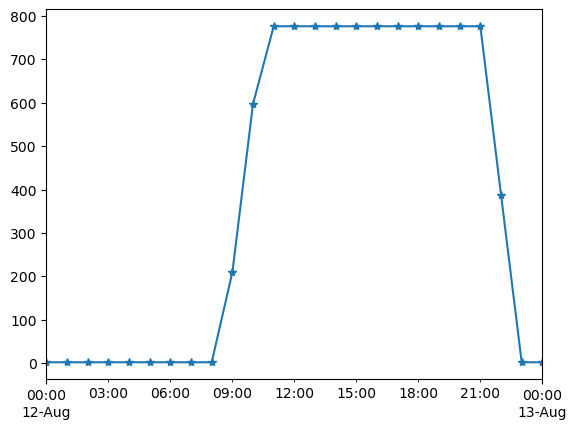

In [25]:
thermal_pg['Astoria 5'].plot(marker='*')

In [26]:
# Save thermal generation to a csv file
resultsdir = '../results'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)
basename = f'thermal_{start_time.strftime("%Y%m%d%H%M")}_{end_time.strftime("%Y%m%d%H%M")}.csv'
filename = os.path.join(resultsdir, basename)
thermal_pg.to_csv(filename)
print(f'Saved thermal generation results in {filename}')

Saved thermal generation results in ../results\thermal_201608120000_201608130000.csv
